In [1]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
import torch.optim as optim
from scipy import linalg
# import opt1d
os.chdir('/home/baly/projects/sopt_shape')

In [2]:
from lib.library import *
from lib.lib_ot import *
from lib.sliced_opt import *
from lib.lib_shape import *


/home/baly/projects/sopt_shape/lib/sliced_opt.py:78: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  X_theta=np.dot(theta,X.T)
/home/baly/projects/sopt_shape/lib/sliced_opt.py:133: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  X_projections=projections.dot(X.T)
/home/baly/projects/sopt_shape/lib/lib_shape.py:485: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  beta=vec_mean(T)-vec_mean(scalar*S.dot(rotation))
/home/baly/projects/sopt_shape/lib/lib_shape.py:503: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  

female


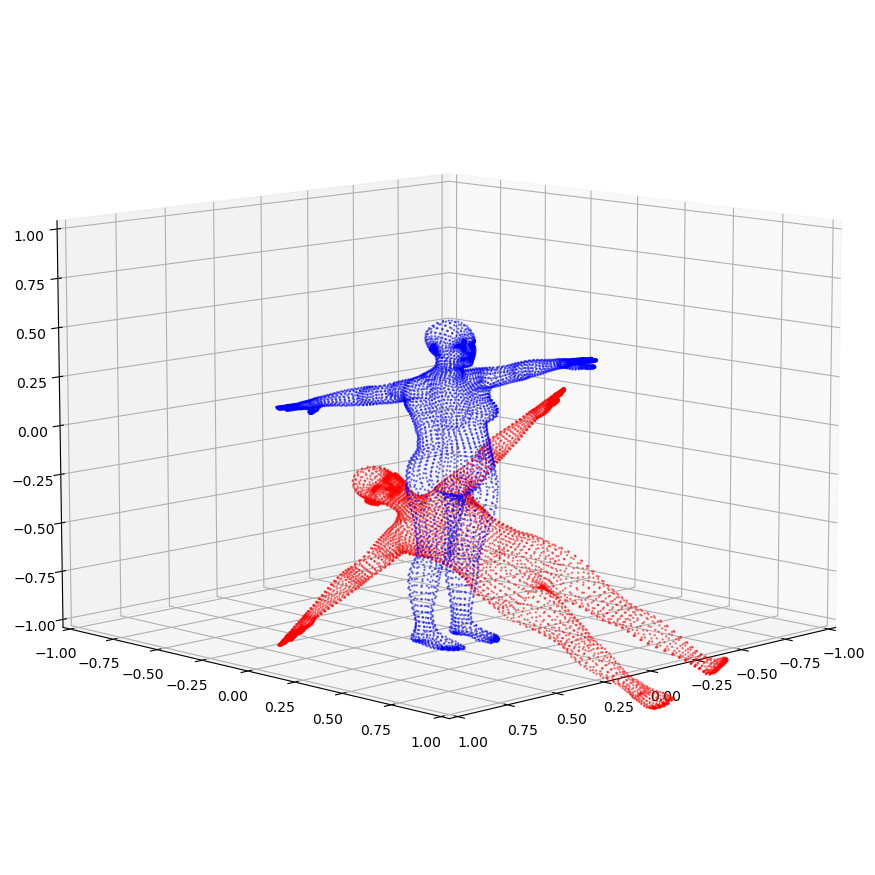

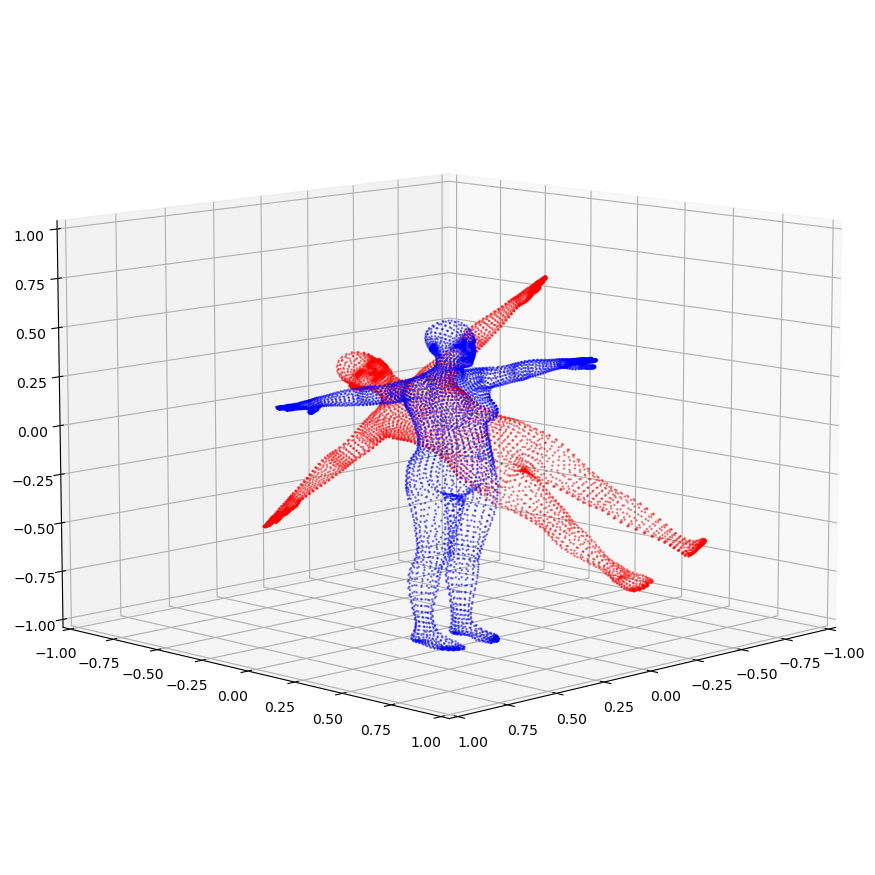

moved


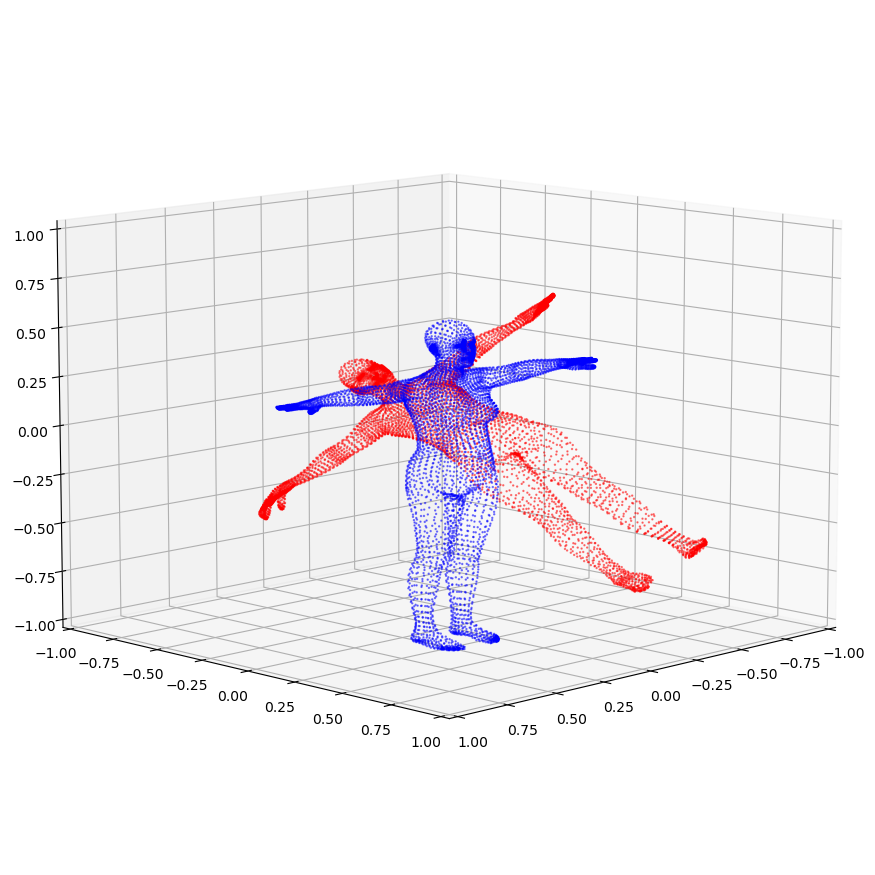

-----
model


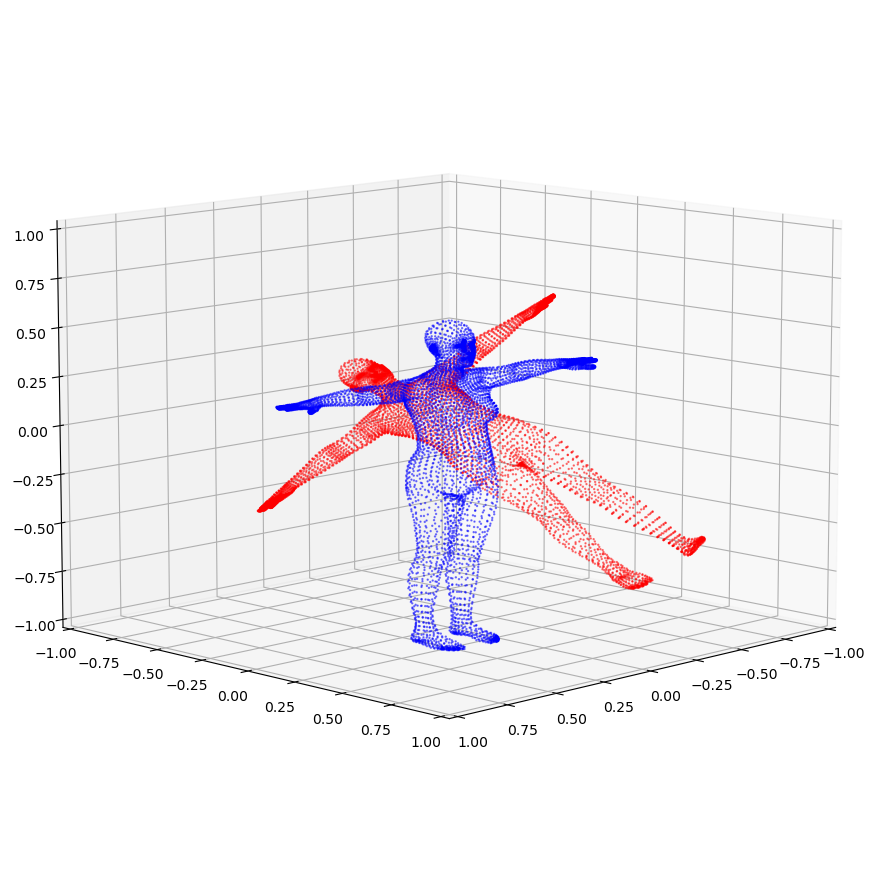

-----
moved


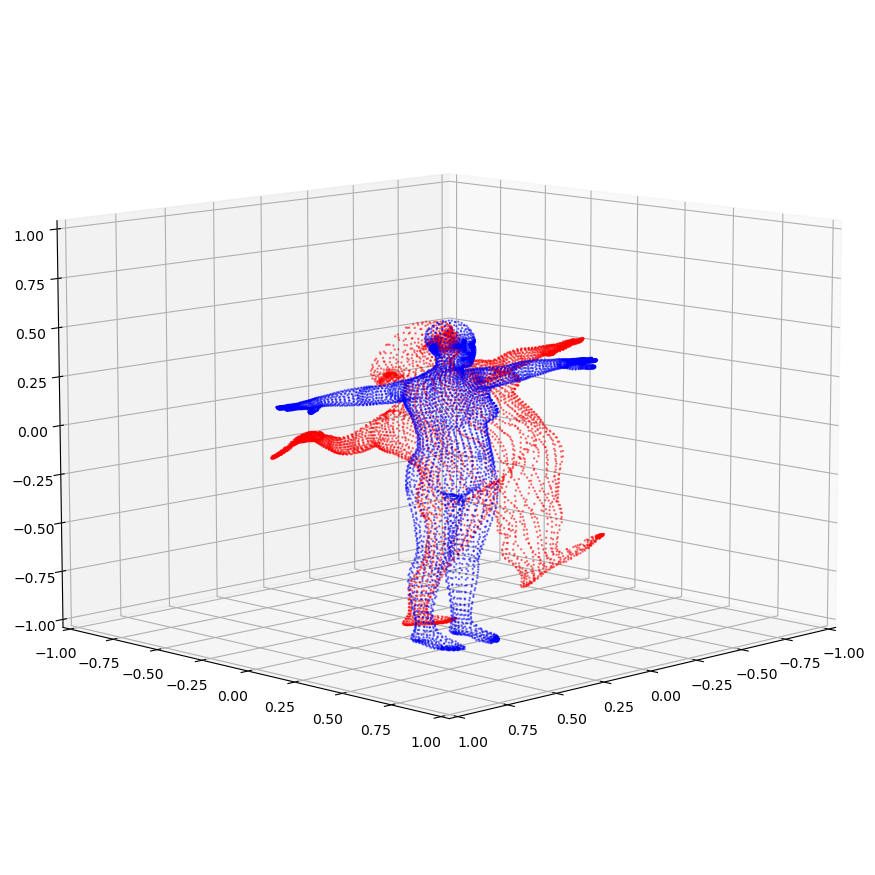

-----
model


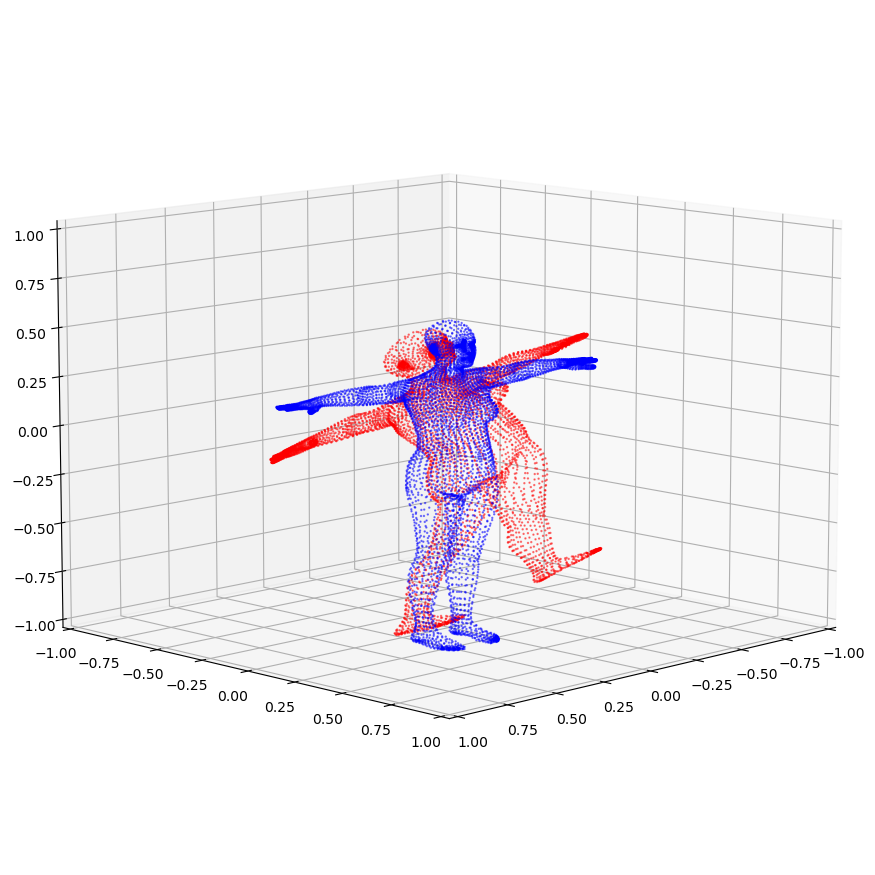

-----
moved


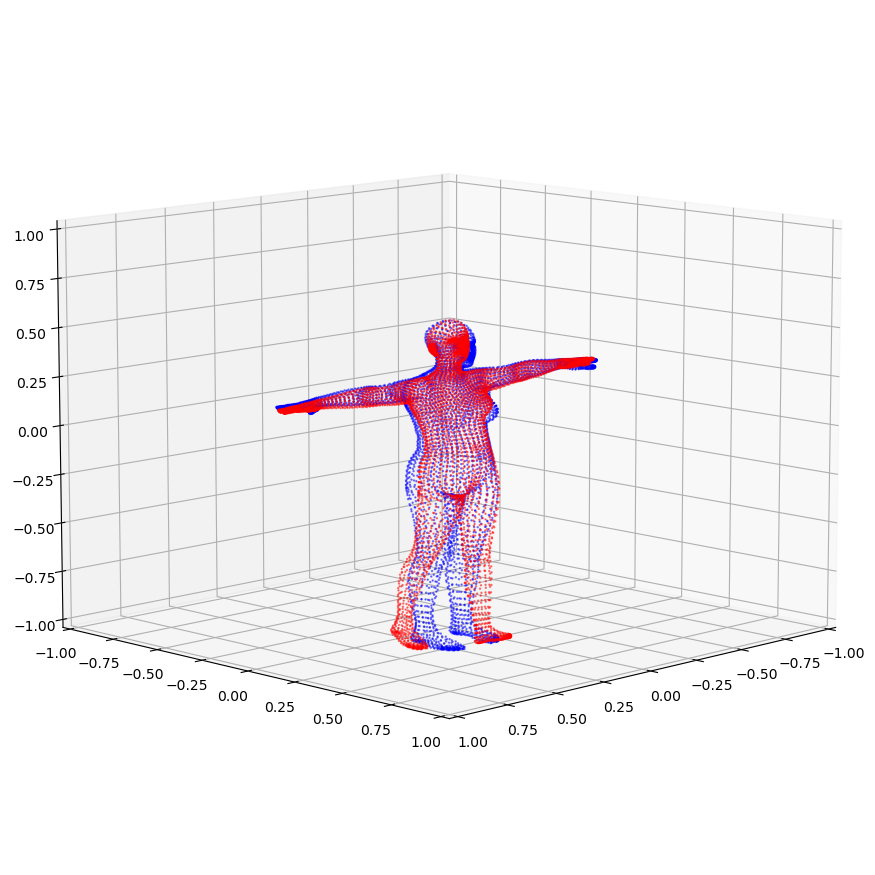

-----
model


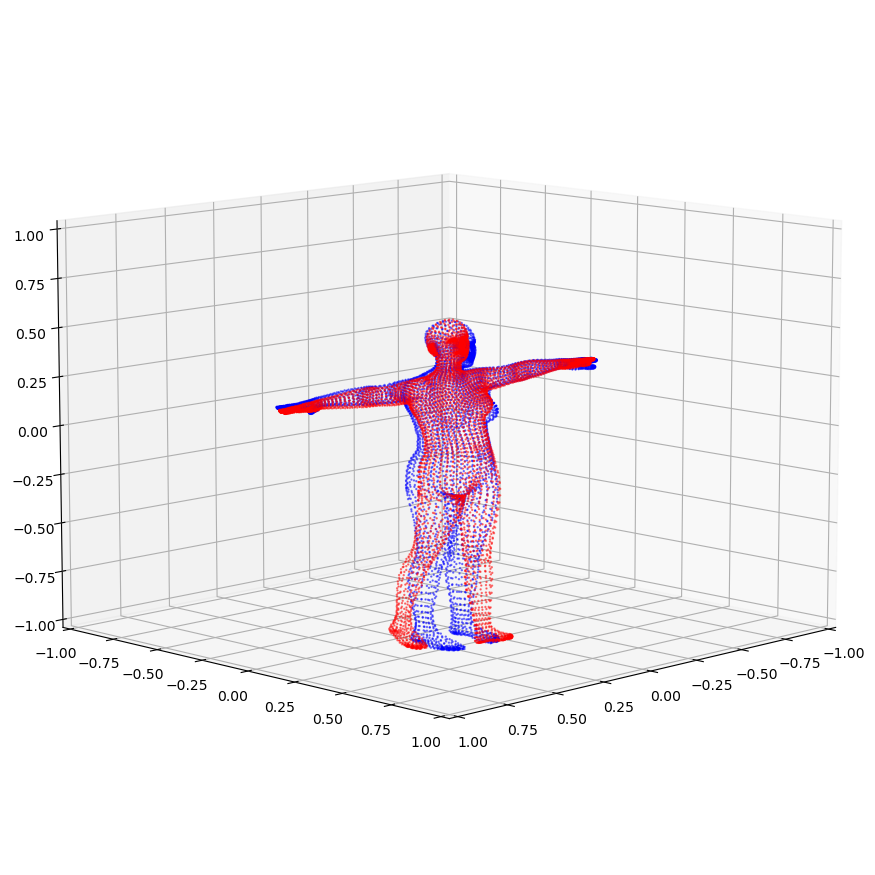

-----
moved


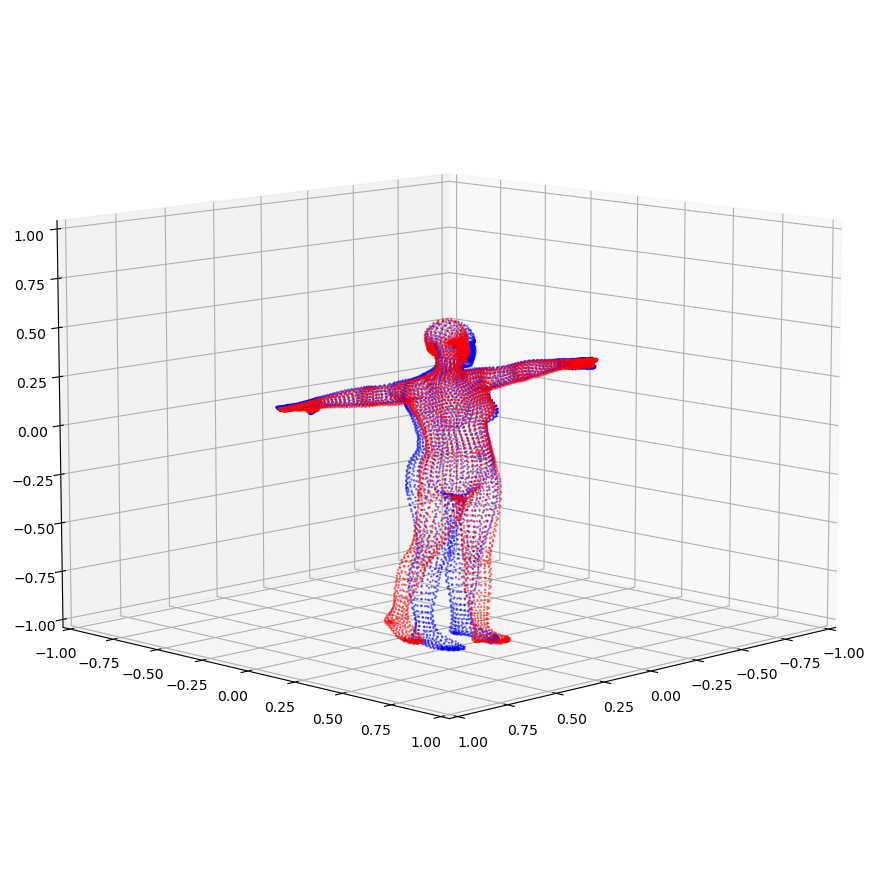

-----
model


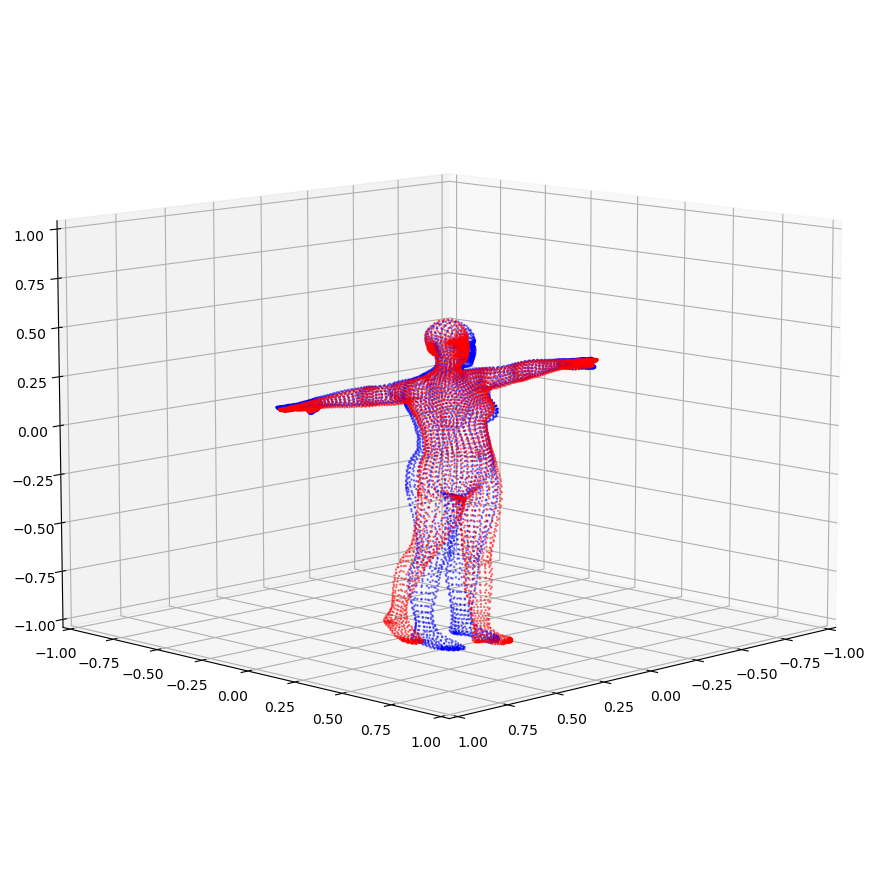

-----


KeyboardInterrupt: 

In [169]:
# load data 
i=19
j=2
sigma2=1e-1
eta=0
label='female'


data=torch.load('data/%s_%d_%d.pt'%(label,i,j))
print(label)
record_index=[0,1,5,10]

C=X.copy()

X0=data['X0']
X=data['X'+str(eta)]
Y=data['Y'+str(eta)]

correspondence=data['permutation'+str(eta)]
Yhat_op=Y[correspondence]

make_plot(X,Y)
N0=X0.shape[0]

N1,D=X.shape
K=N1

sigma2=10
eps=3


# initlize 
R=np.eye(D)    
S=1.0 
beta=vec_mean(Y)-vec_mean(S*X.dot(R)) 
alpha=np.zeros((C.shape[0],D))
        


mass_diff=0
#b=0
b=np.log((N1-N0+1)/1)
Lambda=100*np.sum((vec_mean(Y)-vec_mean(X))**2)
Yhat=Phi.dot(alpha)+S*X.dot(R)+beta
make_plot(Yhat,Y)

X_bar=np.hstack((np.ones((X.shape[0],1)),X))
Delta=Lambda/8
lower_bound=Lambda/10000

# Yhat_list=list()
n_projections=1000
projections=projections=random_projections(D,n_projections,1)

for epoch in range(n_projections): 
    theta=projections[epoch]
    Yhat_theta,Y_theta=np.dot(theta,Yhat.T),np.dot(theta,Y.T)
    Yhat_indice,Y_indice=Yhat_theta.argsort(),Y_theta.argsort()
    Yhat_s,Y_s=Yhat_theta[Yhat_indice],Y_theta[Y_indice]
    obj,phi,psi,piRow,piCol=solve_opt(Yhat_s,Y_s,Lambda)
    piRow=np.arange(N1)
    L=recover_indice(Yhat_indice,Y_indice,piRow)
    Domain,Range=L>=0,L[L>=0]    
    trans_cost=np.sum((Yhat_theta[Domain]-Y_theta[Range])**2)

    Yhat+=np.expand_dims(Y_theta[Range]-Yhat_theta[Domain],1)*theta
    Yhat_theta,Y_theta=np.dot(theta,Yhat.T),np.dot(theta,Y.T)
       


    
    mass=np.sum(Domain)
    N=(N1-N0)*1/(1+b*(epoch/500))+N0
    mass_diff=mass-N
    # print(mass_diff)
    if mass_diff>N*0.009:
        Lambda-=Delta 
    if mass_diff<-N*0.003:
        Lambda+=Delta
        Delta=Lambda*1/8
    if Lambda<Delta:
        Lambda=Delta
        Delta=Delta*1/2
    if Delta<lower_bound:
        Delta=lower_bound

    
    if trans_cost/N1<0.05:
        repeat=5
    else:
        repeat=1
    
    for ind in range(repeat):
    
        # find optimal R,S,beta, conditonal on alpha
        Y_prime2=Yhat[Domain]-Phi[Domain].dot(alpha)

        #Y_prime2=Yhat-Phi.dot(alpha)
        R,S=recover_rotation(Y_prime2,X[Domain])
        beta=vec_mean(Y_prime2)-vec_mean(X[Domain].dot(R))
        # R,S,beta=1/2*R+1/2*R1,1/2*S+1/2*S1,1/2*beta+1/2*beta1

        # update Yhat by alpha, Phi   
        Y_prime=Yhat[Domain]-X[Domain].dot(R)-beta
        alpha=recover_alpha(Phi[Domain],Y_prime,10)
        Yhat=Phi.dot(alpha)+X.dot(R)+beta
    
    if epoch%20==0:
        print('moved')
        make_plot(Yhat,Y)
        print('-----')
    
    Yhat=Phi.dot(alpha)+X.dot(R)+beta
    # print('model')
    # make_plot(Yhat,Yhat)
    # print('-----')
    
    # Yhat_clean=Phi[0:N0,0:N0].dot(alpha[0:N0])+S*X[0:N0].dot(R)+beta
    
    if epoch%20==0:
        print('model')
        make_plot(Yhat,Y)
        print('-----')

    
    
    


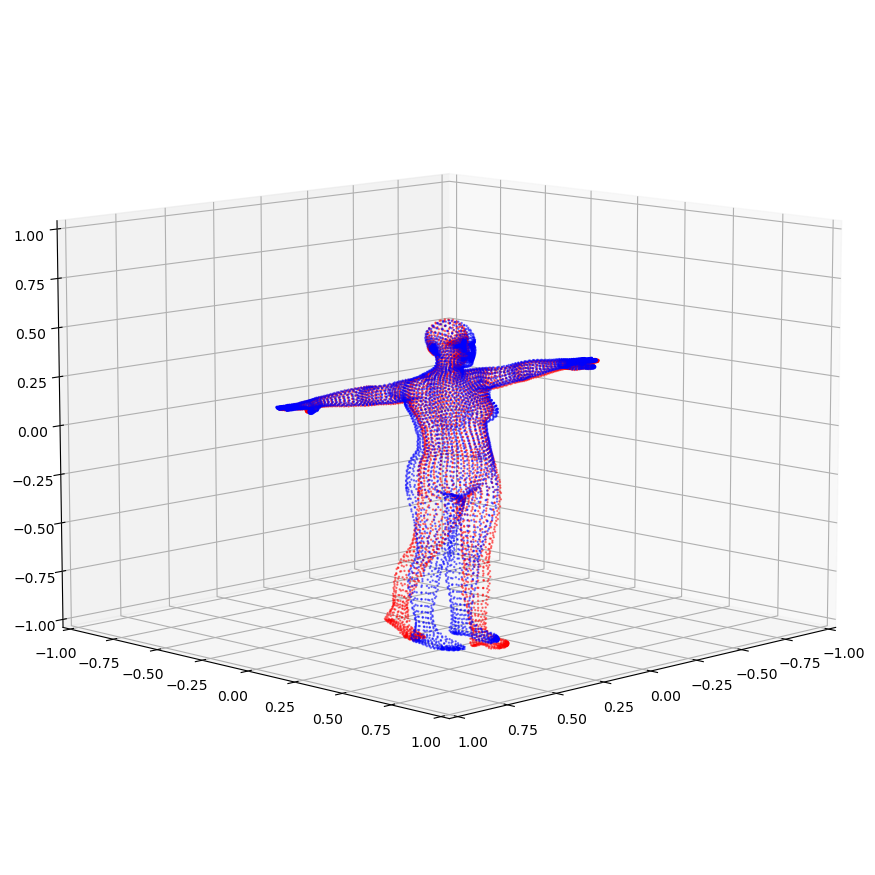

In [168]:
make_plot(Yhat,Y)

In [167]:
obj


0.16530927509302273

In [158]:
Yhat_theta,Y_theta=np.dot(theta,Yhat.T),np.dot(theta,Y.T)
Yhat_indice,Y_indice=Yhat_theta.argsort(),Y_theta.argsort()
Yhat_s,Y_s=Yhat_theta[Yhat_indice],Y_theta[Y_indice]
obj,phi,psi,piRow,piCol=solve_opt(Yhat_s,Y_s,Lambda)
piRow=np.arange(N1)
L=recover_indice(Yhat_indice,Y_indice,piRow)
Domain,Range=L>=0,L[L>=0]    
trans_cost=np.sum(Yhat_theta[Domain]-Y_theta[Range])**2
print('trans_cost',trans_cost)
print('opt cost',obj)

trans_cost 1.5745228680426324e-29
opt cost 0.0


In [155]:
obj

219.8307800978655

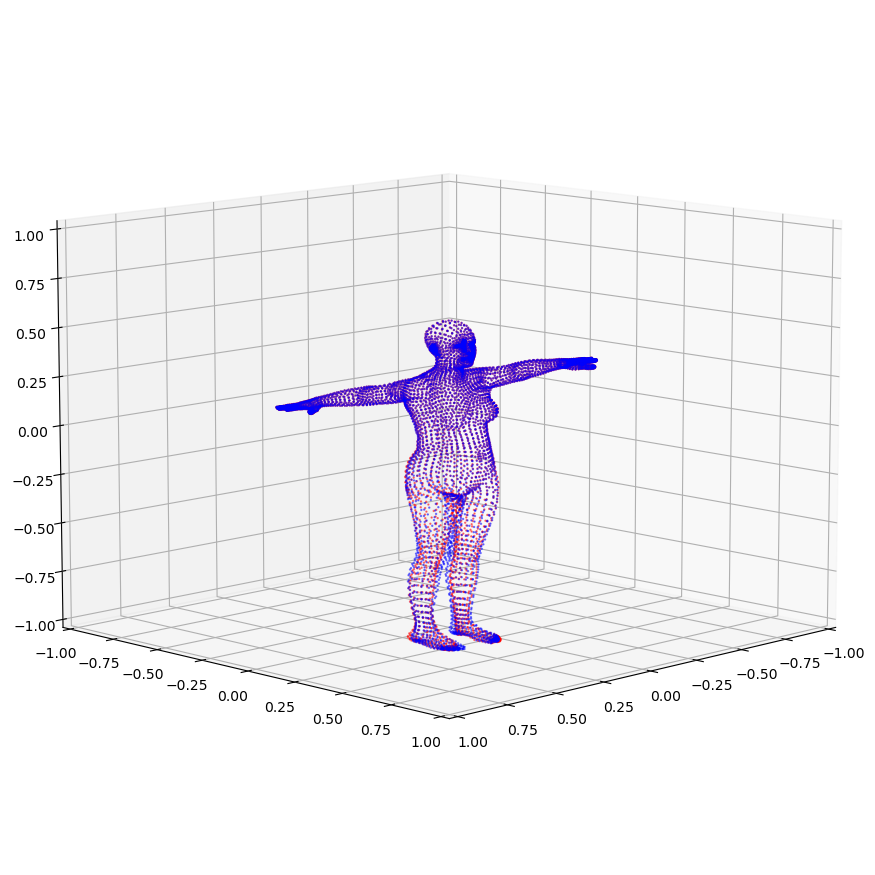

In [133]:
sigma2=10
eps=3
sample_index=np.unique(np.linspace(0,N1-1,200).astype(np.int64))
C=X.copy() 
Phi=kernel_matrix_Gaussian(C,X,sigma2) 
K,D=C.shape
Yhat_op=Y[correspondence]
alpha=np.zeros((K,D))
for i in range(10):
    Y_prime2=Yhat_op-Phi.dot(alpha)
    R,S=recover_rotation(Y_prime2,X[Domain])
    beta=vec_mean(Y_prime2)-vec_mean(X[Domain].dot(R))
    # update Yhat by alpha, Phi   
    Y_prime=Yhat1-X.dot(R)-beta
    alpha=recover_alpha_cuda(Phi,Y_prime,10)    
    Yhat=Phi.dot(alpha)+X.dot(R)+beta

make_plot(Yhat2,Y)

In [2]:
# our method 1: 
# input, X, Y, N0, n_projetions,
# output Yhat_list

# load data 
i=19
j=2
label='female'
data=torch.load('data/%s_%d_%d.pt'%(label,i,j))
print(label)


#C=X.copy()
#K=600 # # of centers
# our method
#@nb.njit()

method='sopt_Gaussian'
sigma2=0.001
eps=0.001
n_projections=300
middle_point=100
record_index1=np.linspace(0,middle_point,50).astype(np.int64)
record_index2=np.linspace(middle_point,n_projections-1,50).astype(np.int64)
record_index=np.unique(np.concatenate((record_index1,record_index2)))
record_index.sort()


for eta in [0.05,0.10]:
    print('label is %s,method is %s, eta is %0.2f'%(label,method,eta))
    X0=data['X0']
    N0=X0.shape[0]
    X=data['X'+str(eta)]
    Y=data['Y'+str(eta)]

    time_start=time.time()
    Yhat_list,_=sopt_Gaussian_cuda(X,Y,N0,n_projections=n_projections,sigma2=sigma2,eps=eps,record_index=record_index)
    time_end=time.time()
    result={}
    result['Yhat_list']=Yhat_list
    result['time']=time_end-time_start
    torch.save(result,'result/3D_%s/%s_%0.2f.pt'%(label,method,eta))
    error=np.linalg.norm((Yhat_list[-1][0:N0]-Y[0:N0])/np.std(Y[0:N0]))/N0
    print('error', error)

female
label is female,method is sopt_Gaussian, eta is 0.05


NameError: name 'sopt_Gaussian_cuda' is not defined

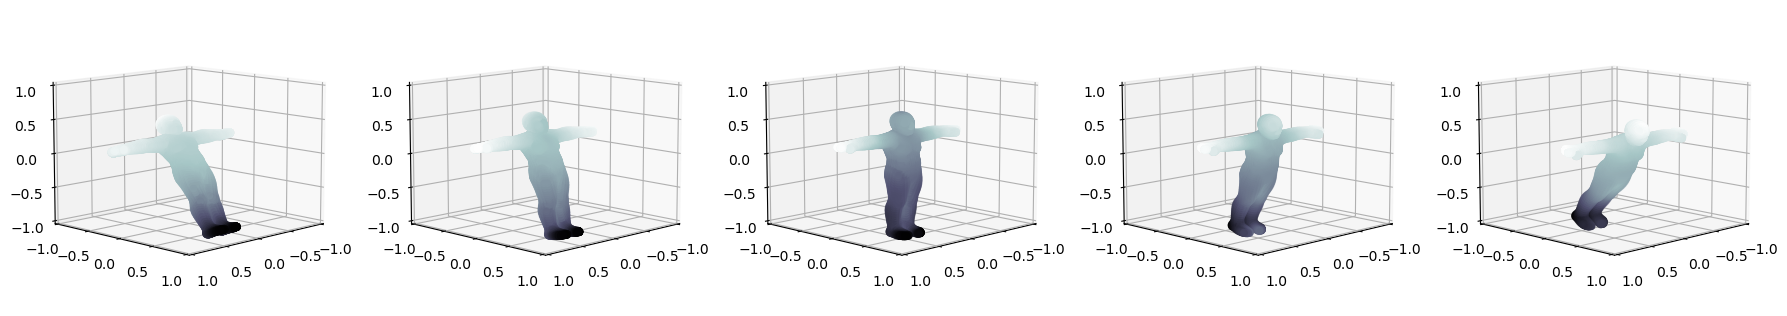

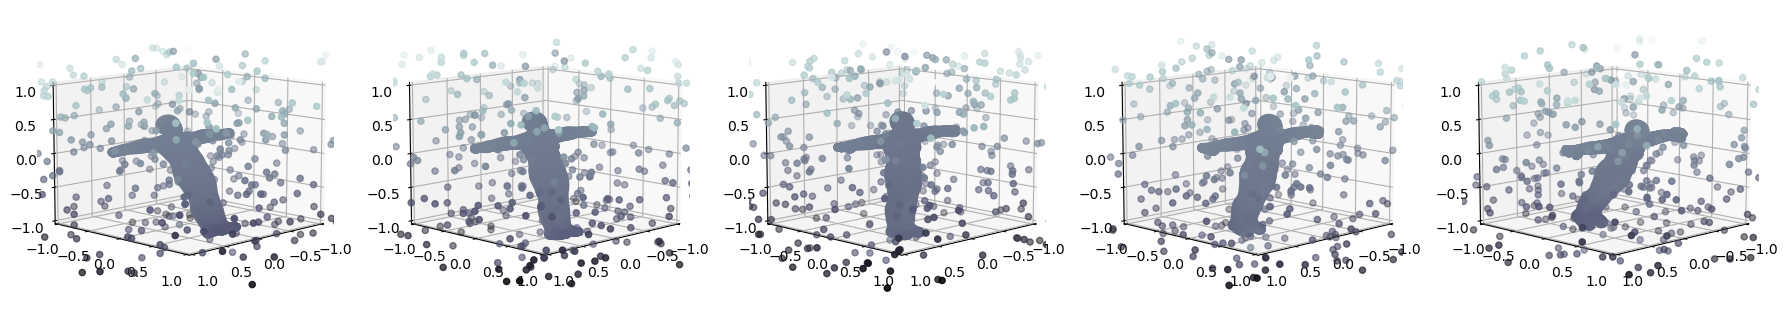

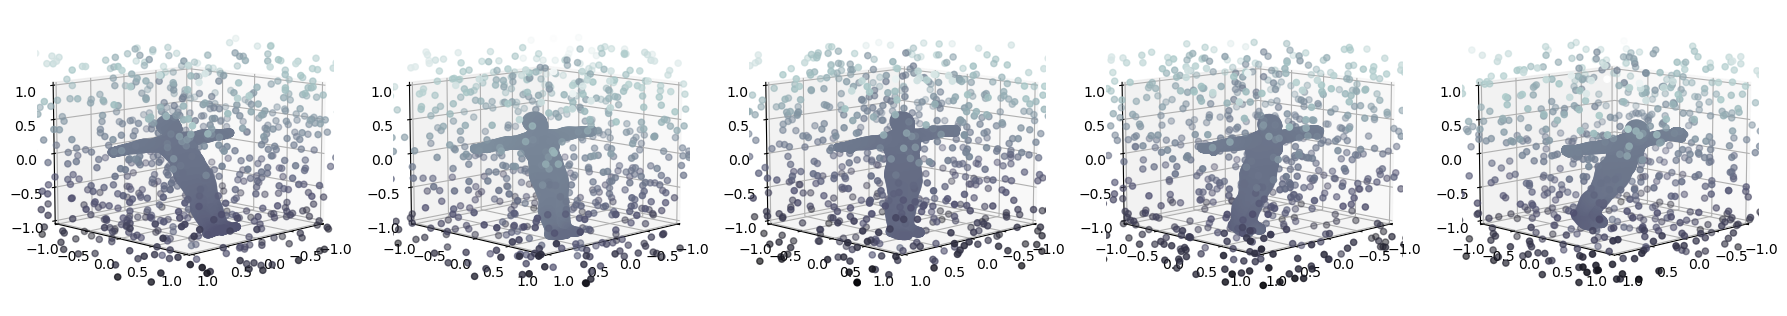

In [309]:
# do not run this one 
label='neutral'
data_list=torch.load('data/'+label+'_list.pt')
#data_list=np.array(data_list)
data_all={}

X=data_list[0] 
Y=data_list[-1]
n,d=X.shape


fig = plt.figure(figsize=(2*800/72,800/72))    
for n,i in enumerate(np.linspace(-.5,.5,5)):
    ax = fig.add_subplot(1, 5, n+1, projection='3d')
    data=data_list[n]
    x=data[:,0]
    y=data[:,1]
    z=data[:,2]
    ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
    ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
    ax.view_init(10, 45)
plt.show()
data_all['0']=data_list


# generate 5% noisy data
n,d=X.shape
data_listY1=[]
eta=0.05
n_noise=int(n*eta)
fig = plt.figure(figsize=(2*800/72,800/72))   
for n,data in enumerate(data_list):

    noise=np.random.uniform(low=-1.5,high=1.5,size=(n_noise,d))
    data=np.concatenate((data,noise))
    x=data[:,0]
    y=data[:,1]
    z=data[:,2]
    if n<=4:
        ax = fig.add_subplot(1, 5, n+1, projection='3d')
        ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
        ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
        ax.view_init(10, 45)
    data_listY1.append(data)
plt.show()

data_all[str(eta)]=data_listY1


# generate 10% noisy data
n,d=X.shape
data_listY1=[]
eta=0.10
n_noise=int(n*eta)
fig = plt.figure(figsize=(2*800/72,800/72))   
for n,data in enumerate(data_list):
    
    noise=np.random.uniform(low=-1.5,high=1.5,size=(n_noise,d))
    data=np.concatenate((data,noise))
    if n<=4:
        ax = fig.add_subplot(1, 5, n+1, projection='3d')
        x=data[:,0]
        y=data[:,1]
        z=data[:,2]
        ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
        ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
        ax.view_init(10, 45)
    data_listY1.append(data)
plt.show()
data_all[str(eta)]=data_listY1

torch.save(data_all,'data/select_'+label+'.pt')


0
0.05
0.1


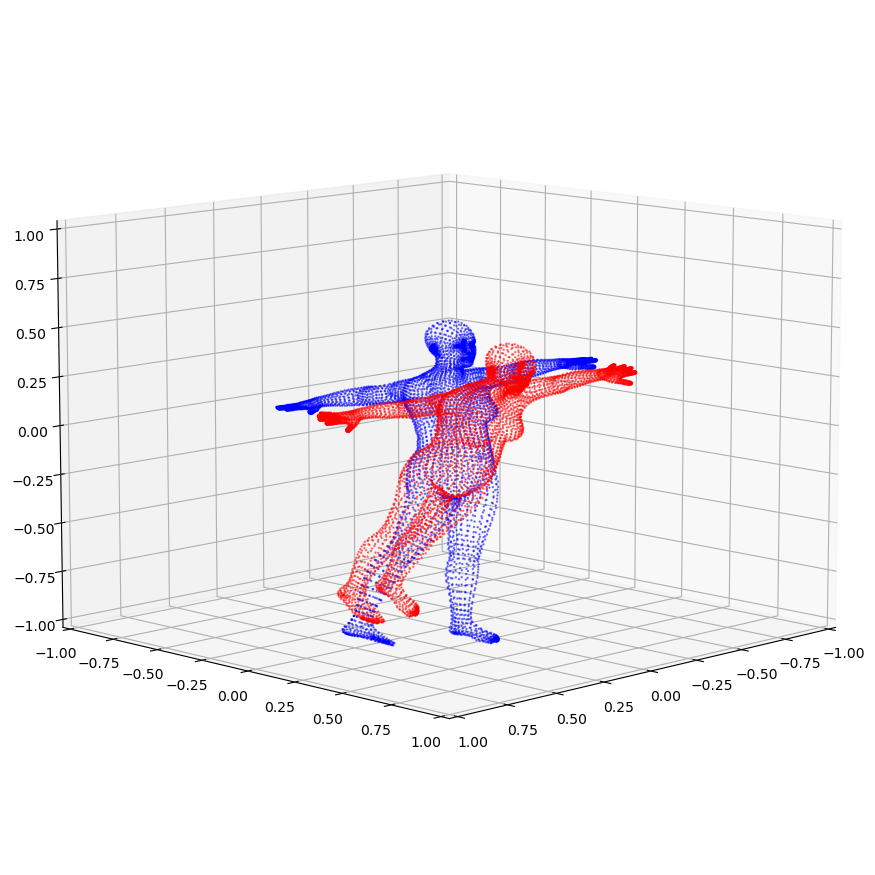

In [47]:
#@nb.njit(fastmath=True)
def kernel_matrix_Gaussian(c,x,sigma2):
    '''
    x: (n,d) numpy array
    c: (n,d) numpy array
    '''
   
    K,d=c.shape
    n=x.shape[0]
    #r2=np.zeros((n,K))
    diff_matrix=np.expand_dims(x,1)-np.expand_dims(c,0)
    r2=np.sum(np.square(diff_matrix),axis=2)
    Phi=np.zeros((n,d))
    Phi=Gaussian_kernel(r2,sigma2)
    return Phi



In [48]:

@nb.njit()
def permutation_inverse(permutation):
    N=permutation.shape[0]
    Domain=np.arange(N)
    mapping=np.stack((Domain,permutation))
    mapping_final=mapping[0].take(mapping[1].argsort())
    return mapping_final

In [49]:
X=np.random.rand(3)
Y=np.random.rand(4)
L=np.array([-1,1,3])
indice_X,indice_Y=X.argsort(),Y.argsort()

indice_Y_mapped=np.where(L>=0,indice_Y[L],-1)
mapping=np.stack((indice_X,indice_Y_mapped))
mapping_final=mapping[1].take(mapping[0].argsort())
print(X)
print(Y)
print(mapping_final)

[0.85649164 0.38427187 0.59900306]
[0.11251565 0.94603908 0.4191567  0.0142474 ]
[ 1 -1  0]


In [50]:
D=2
n=100
X=np.random.rand(n,D)
Y=X+0.02
n_projections=20
projections=random_projections(D,n_projections,1)
A=X_correspondence_ot(X,Y,projections)

NameError: name 'X_correspondence_ot' is not defined

[-0.04908432  0.07412116  0.04115355  0.0286485  -0.30746179  0.01812976
 -0.11882372 -0.10380873  0.09698842  0.01675899]
[ 0.01675899  0.07412116  0.01812976  0.04115355  0.0286485  -0.04908432
 -0.30746179  0.09698842 -0.10380873 -0.11882372]


In [455]:
@torch.jit.script   
def recover_indice_T(indice_X,indice_Y,L):
    '''
    input:
        indice_X: n*1 float torch tensor, whose entry is integer 0,1,2,....
        indice_Y: m*1 float torch tensor, whose entry is integer 0,1,2,.... 
        L: n*1 list, whose entry could be 0,1,2,... and -1.
        L is the original transportation plan for sorted X,Y 
        L[i]=j denote x_i->y_j and L[i]=-1 denote we destroy x_i. 
        If we ignore -1, it must be in increasing order  
    output:
        mapping_final: the transportation plan for original unsorted X,Y
        
        Eg. X=[2,1,3], indice_X=[1,0,2]
            Y=[3,1,2], indice_Y=[1,2,0]
            L=[0,1,2] which means the mapping 1->1, 2->2, 3->3
        return: 
            L=[2,1,0], which also means the mapping 2->2, 1->1,3->3.
    
    '''
    device=indice_X.device.type
    n=L.shape[0]
#    indice_Y_mapped=torch.tensor([indice_Y[i] if i>=0 else -1 for i in L],device=device)
    indice_Y_mapped=torch.where(L>=0,indice_Y[L],-1).to(device) 
    mapping=torch.stack([indice_X,indice_Y_mapped])
    mapping_final=mapping[1].take(mapping[0].argsort())
    return mapping_final



@nb.njit(['int64[:](int64[:],int64[:],int64[:])'],cache=True)
def recover_indice(indice_X,indice_Y,L):
    '''
    input:
        indice_X: n*1 float torch tensor, whose entry is integer 0,1,2,....
        indice_Y: m*1 float torch tensor, whose entry is integer 0,1,2,.... 
        L: n*1 list, whose entry could be 0,1,2,... and -1.
        L is the original transportation plan for sorted X,Y 
        L[i]=j denote x_i->y_j and L[i]=-1 denote we destroy x_i. 
        If we ignore -1, it must be in increasing order  
    output:
        mapping_final: the transportation plan for original unsorted X,Y
        
        Eg. X=[2,1,3], indice_X=[1,0,2]
            Y=[3,1,2], indice_Y=[1,2,0]
            L=[0,1,2] which means the mapping 1->1, 2->2, 3->3
        return: 
            L=[2,1,0], which also means the mapping 2->2, 1->1,3->3.
    
    '''
    n=L.shape[0]
    indice_Y_mapped=np.where(L>=0,indice_Y[L],-1)
    mapping=np.stack((indice_X,indice_Y_mapped))
    mapping_final=mapping[1].take(mapping[0].argsort())
    return mapping_final

/tmp/ipykernel_559358/930000915.py:52: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  indice_Y_mapped=np.where(L>=0,indice_Y[L],-1)


In [469]:
n=10
X_theta=np.random.rand(n)
Y_theta=np.random.rand(n)
X_indice=X_theta.argsort()
Y_indice=Y_theta.argsort()
X_s=X_theta[X_indice]
Y_s=Y_theta[Y_indice]
L=np.arange(n)

L1=recover_indice(X_indice,Y_indice,L)
error1=(X_theta-Y_theta[L1])
error2=(X_s-Y_s)
error1.sort()
error2.sort()
print(error1-error2)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0.76655816 0.34963733 0.79701866]
[0.72885973 0.17009141 0.93791983]
[0.34963733 0.76655816 0.79701866]
[0.17009141 0.72885973 0.93791983]


In [457]:
X_s

array([0.05997619, 0.12193383, 0.15151828, 0.16809913, 0.20658398,
       0.39166815, 0.40361619, 0.45353675, 0.56783493, 0.57072843])

In [401]:
Yhat_theta=np.random.rand(10)
Y_theta=np.random.rand(10)

Yhat_indice,Y_indice=Yhat_theta.argsort(),Y_theta.argsort()
Yhat_s,Y_s=Yhat_theta[Yhat_indice],Y_theta[Y_indice]
    # obj2,phi,psi,piRow,piCol=opt1d.solve(Yhat_s,Y_s,Lambda)
    # L=piRow.copy().astype(np.int64)
L1=np.arange(10)
L=recover_indice(Yhat_indice,Y_indice,L1)
a1=np.linalg.norm(Y_s-Yhat_s)
a2=np.linalg.norm(Y_theta[L]-Yhat_theta)


0.0


female


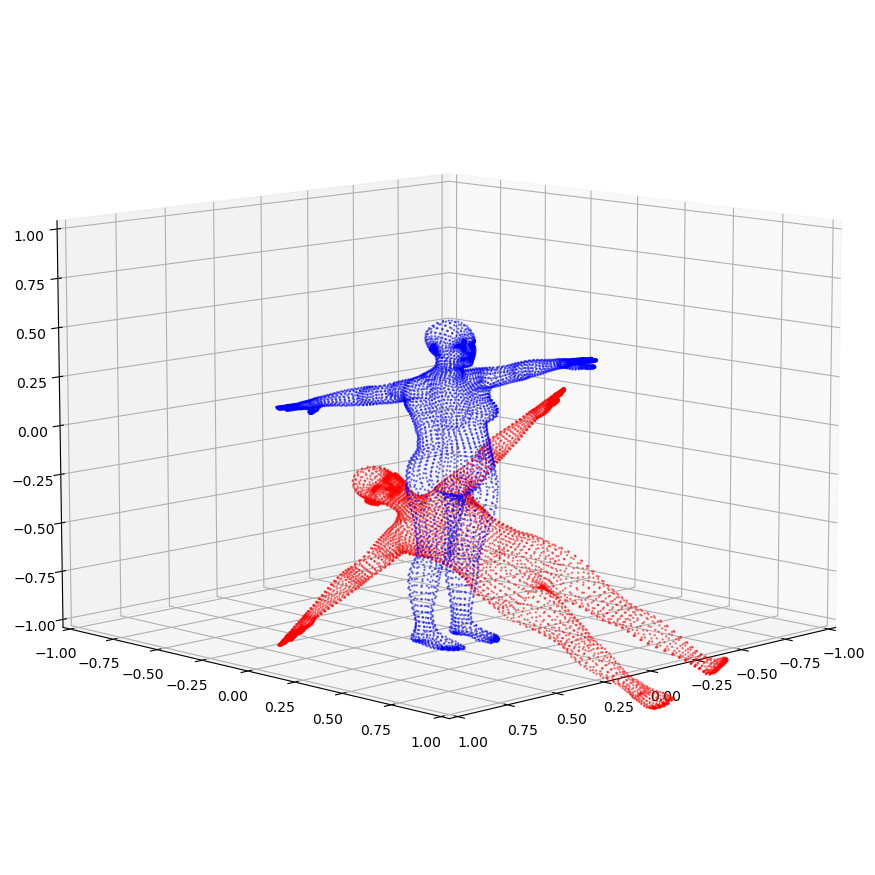

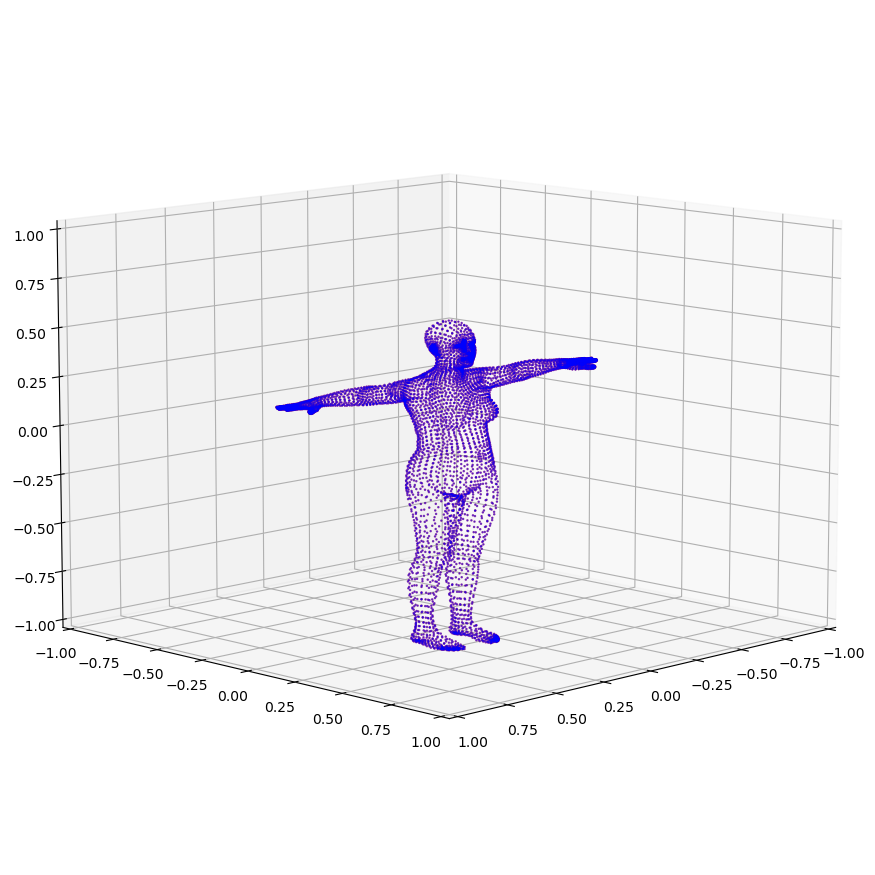

model


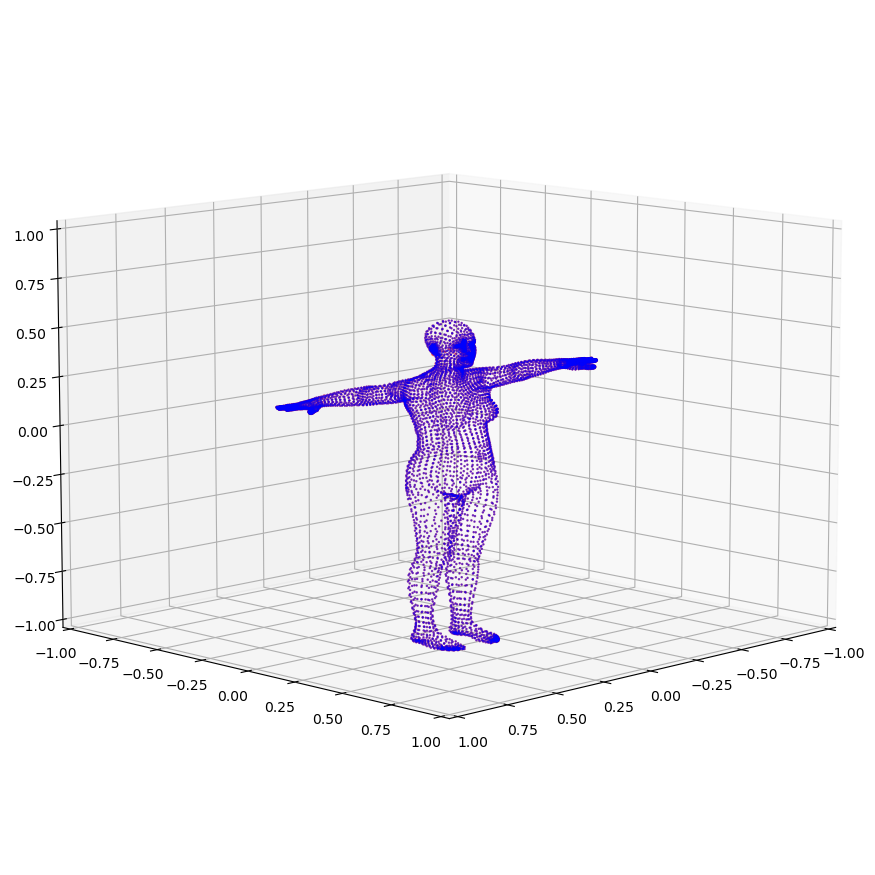

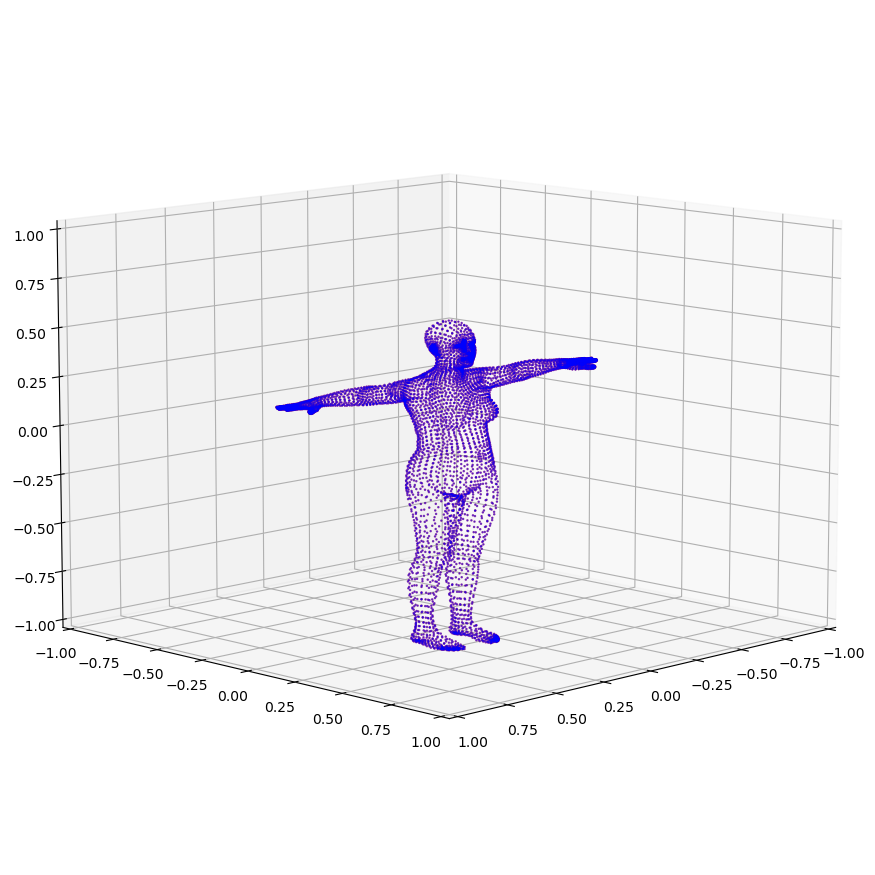

model


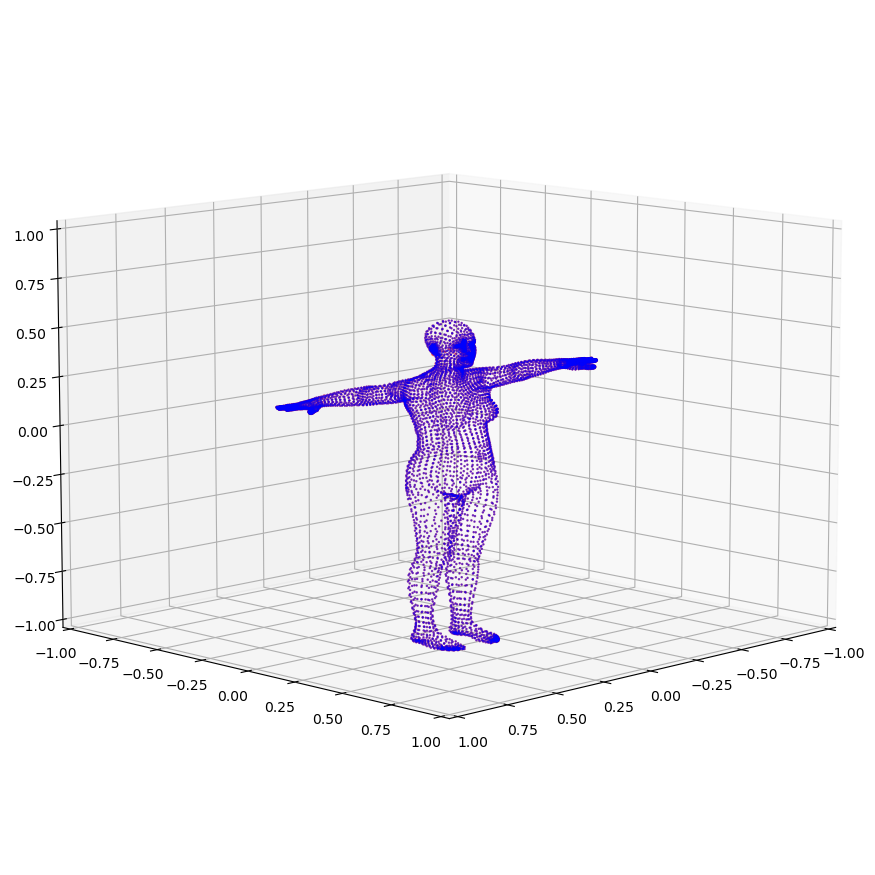

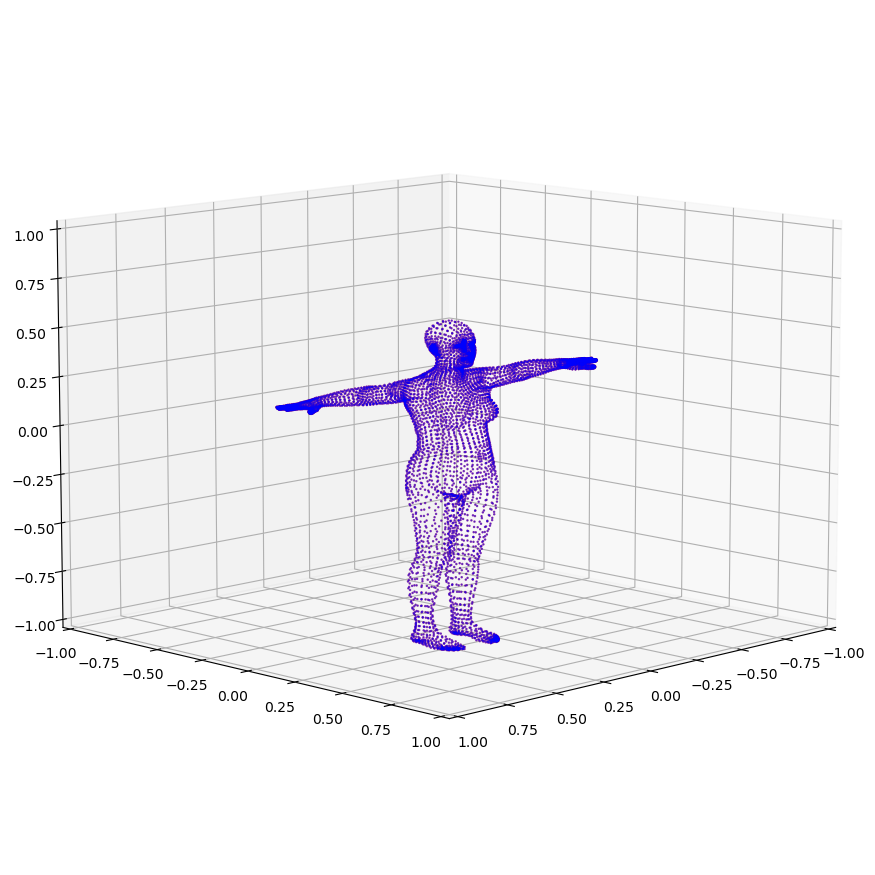

model


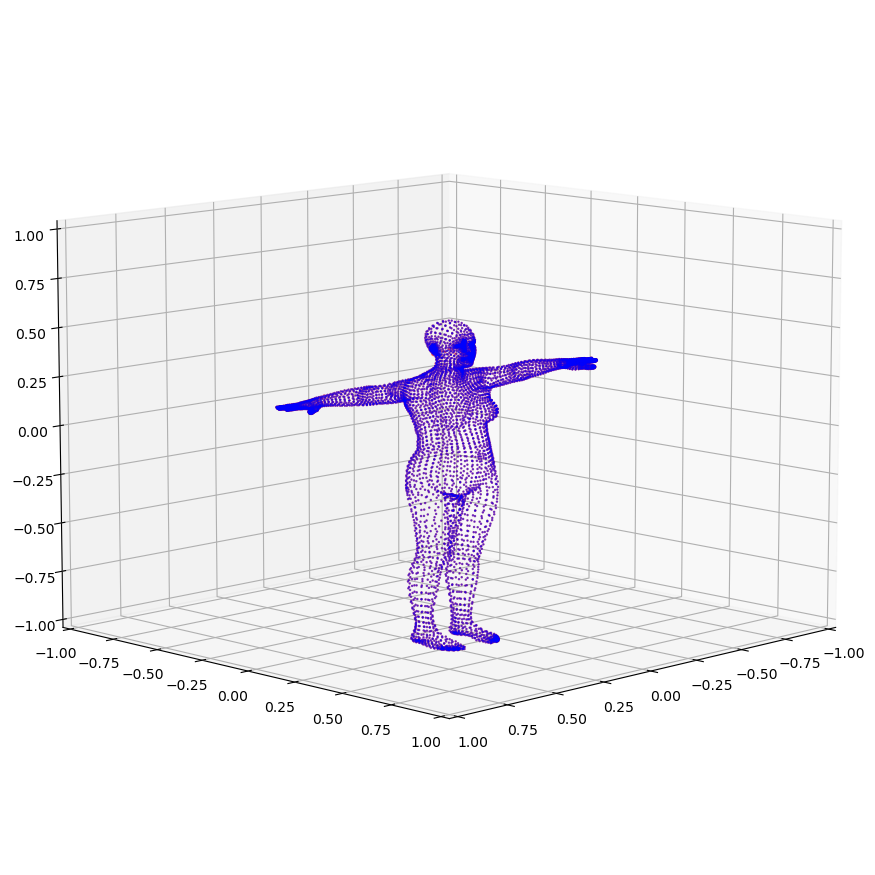

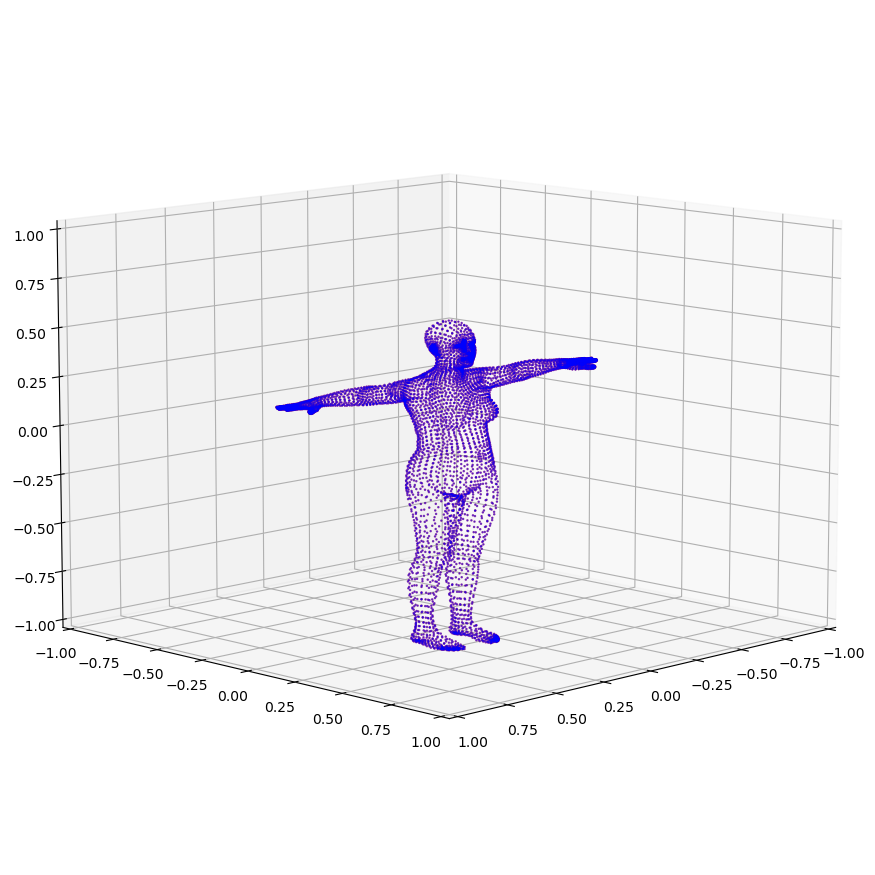

model


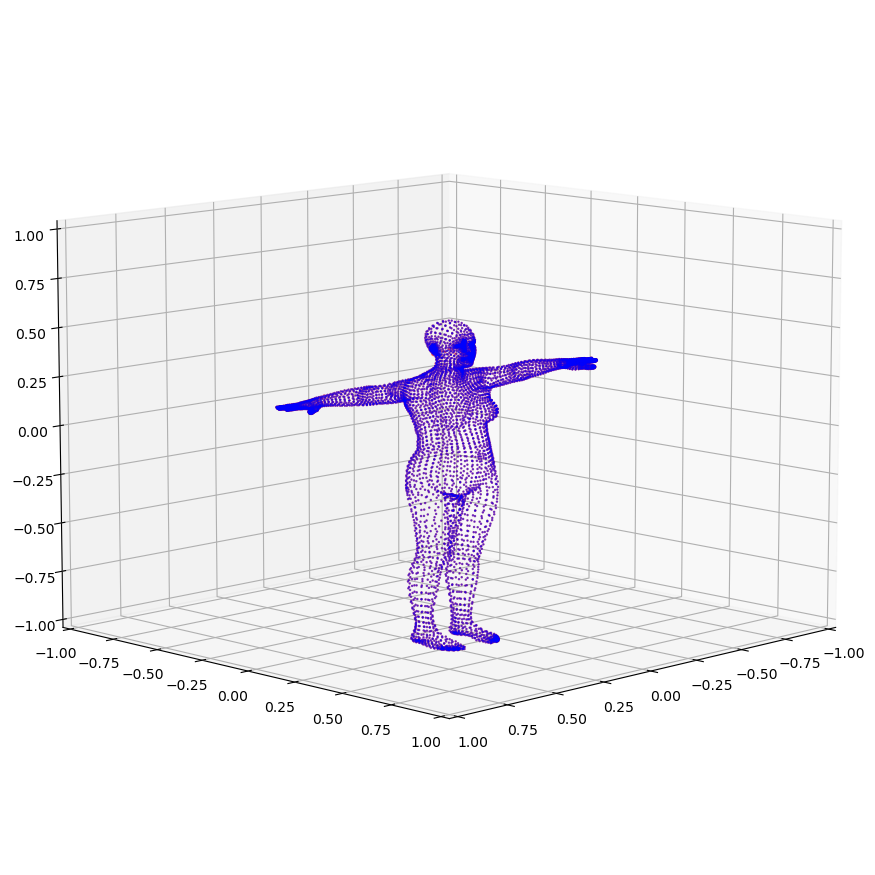

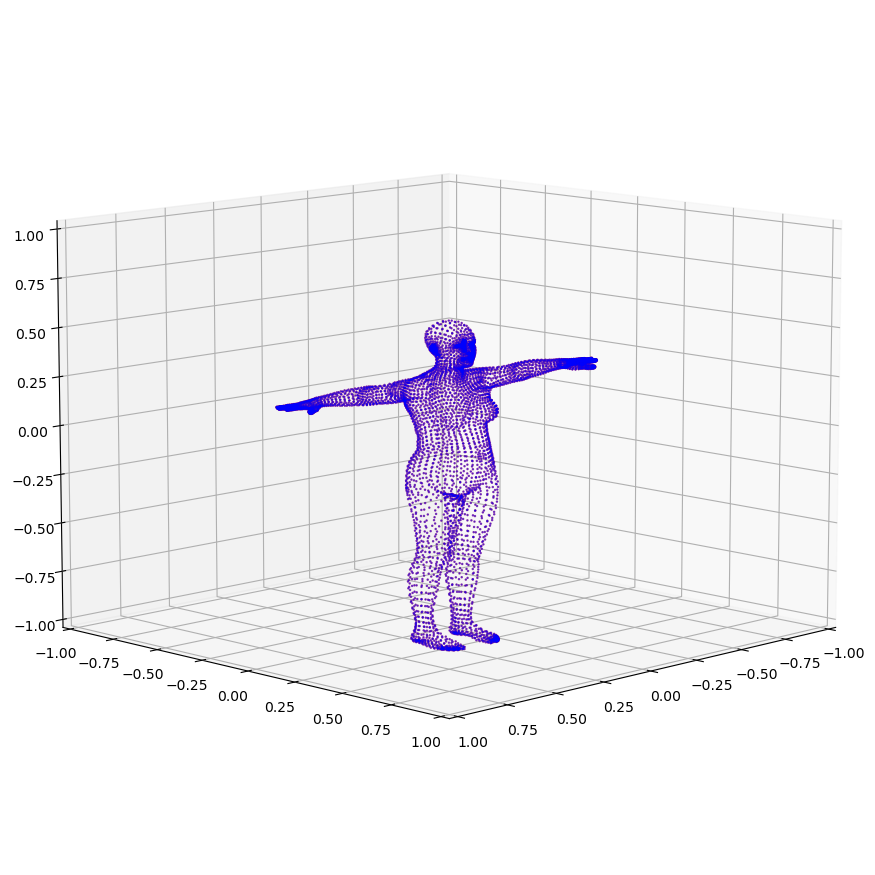

model


KeyboardInterrupt: 

In [350]:
# load data 
i=19
j=2
sigma2=1e-5
eta=0
label='female'
eps=1e-6
n_projections=1000
data=torch.load('data/%s_%d_%d.pt'%(label,i,j))
print(label)
record_index=[0,1,5,10]

X0=data['X0']
X=data['X'+str(eta)]
Y=data['Y'+str(eta)]

correspondence=data['permutation'+str(eta)]
make_plot(X,Y)
N0=X0.shape[0]


N1,D=X.shape
K=N1
C=X.copy()

Phi=kernel_matrix_Gaussian(C,X,sigma2) 

# initlize 
R=np.eye(D)    
S=1.0 
beta=np.zeros(D) #vec_mean(Y)-vec_mean(S*X.dot(R)) 
alpha=np.zeros((C.shape[0],D))

#paramlist=[]

mass_diff=0
#b=0
b=np.log((N1-N0+1)/1)
Lambda=100*np.sum((vec_mean(Y)-vec_mean(X))**2)
Yhat=Phi.dot(alpha)+S*X.dot(R)+beta
# make_plot(Yhat,Y)

Domain_org=arange(0,N1)
Delta=Lambda/8
lower_bound=Lambda/10000
L=Domain_org.copy()
mu,nu=np.ones(N1),np.ones(N1)

Yhat_list=list()
for (epoch,theta) in enumerate(projections):    
    # compute correspondence
    #M=cost_matrix_d(Yhat,Y)
    #gamma=ot.lp.emd(mu, nu, M, numItermax=600000, log=False, numThreads=10)
    

    #move selected Yhat
    
    Domain=Domain_org
    Yhat=gamma.dot(Y)
    make_plot(Yhat,Y)
    
    #Yhat[Domain]+=np.expand_dims(Y_theta[Range]-Yhat_theta[Domain],1)*theta

    # find optimal R,S,beta, conditonal on alpha
    
    # Y_prime2=Yhat[Domain]-Phi[Domain].dot(alpha)
    # R,S=recover_rotation(Y_prime2,X[Domain])
    # beta=vec_mean(Y_prime2)-vec_mean(X[Domain].dot(R))

    # update Yhat by alpha, Phi 
#    elif epoch%2==1:
    Y_prime=Yhat[Domain]-X[Domain].dot(R)-beta
    alpha=recover_alpha(Phi[Domain],Y_prime)
    #error2=np.linalg.norm(Y_prime-Phi.dot(alphaa))
    
    #print('error from alpha is',np.linalg.norm(Phi.dot(alpha)[Domain]-Y_prime))

    # update selected points 
    # model 1
    Yhat=Phi.dot(alpha)+S*X.dot(R)+beta
    print('model')
    make_plot(Yhat,Y)

    # update lambda 
    # N=(N1-N0)*1/(1+b*(epoch/500))+N0
    # mass_diff=mass-N
    # if mass_diff>N*0.009:
    #     Lambda-=Delta 
    # if mass_diff<-N*0.003:
    #     Lambda+=Delta
    #     Delta=Lambda*1/8
    # if Lambda<Delta:
    #     Lambda=Delta
    #     Delta=Delta*1/2
    # if Delta<lower_bound:
    #     Delta=lower_bound
    # if epoch%10==0:
    #     make_plot(Yhat,Y)
    #error=np.linalg.norm((Yhat[0:N0]-Y[correspondence])/np.std(Y[0:N0]))/N0
    #print('error', error)
    
    # if epoch in record_index or epoch==n_projections-1:
    #     Yhat_list.append(Yhat)

In [366]:
np.linalg.norm(Yhat-Y)

6.145848955212534e-05

Lambda

In [349]:
X.shape

(6890, 3)

In [335]:
error=np.linalg.norm((Yhat[0:N0]-Y[correspondence])/np.std(Y[0:N0]))/N0
print('error', error)

error 0.012062002012341737


In [258]:
X=np.random.rand(5,3)
Y=X+np.random.rand(5,3)
signma2=1e-4
Phi=kernel_matrix_Gaussian(X,X,sigma2)
alpha=recover_alpha(Phi,Y)
Yhat=Phi.dot(alpha)
error=np.linalg.norm(Yhat-Y)
print(error)

0.0003618981229353809


In [209]:
data=torch.load('data/female_%d_%d.pt'%(i,j))
X0=data['X0']
X=data['X'+str(eta)]
Y=data['Y'+str(eta)]
#make_plot(X,Y)
N0=X0.shape[0]

N1,D=X.shape
C=X.copy()
sigma2=1e-4
Phi=kernel_matrix_Gaussian(C,X,sigma2) 


AttributeError: 'numpy.ndarray' object has no attribute 'diag'

In [210]:
Phi.diag()

AttributeError: 'numpy.ndarray' object has no attribute 'diag'

female


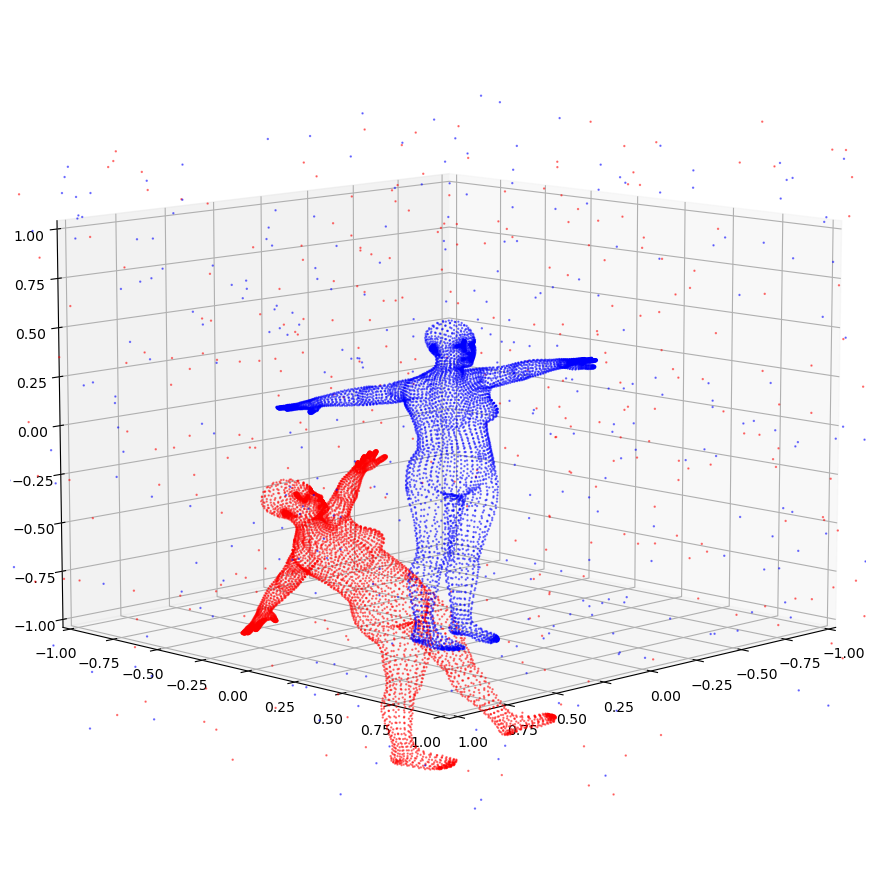

epoch 0
Lambda 40.34823162085958


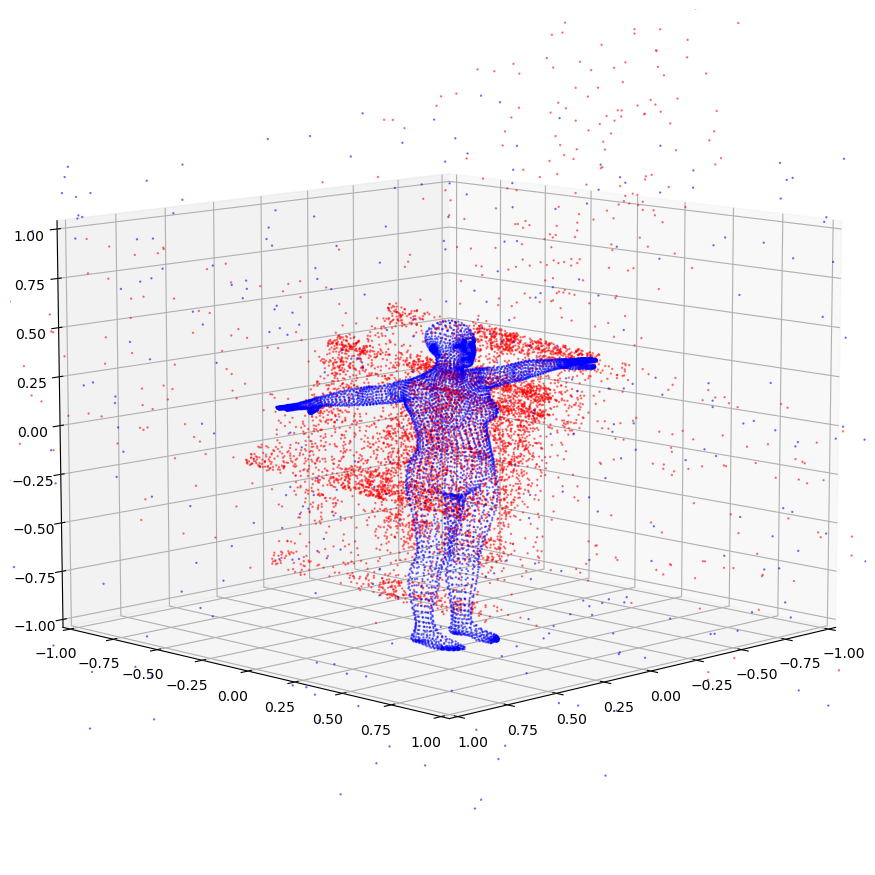

error 0.03145222786552691
epoch 1
Lambda 40.34823162085958


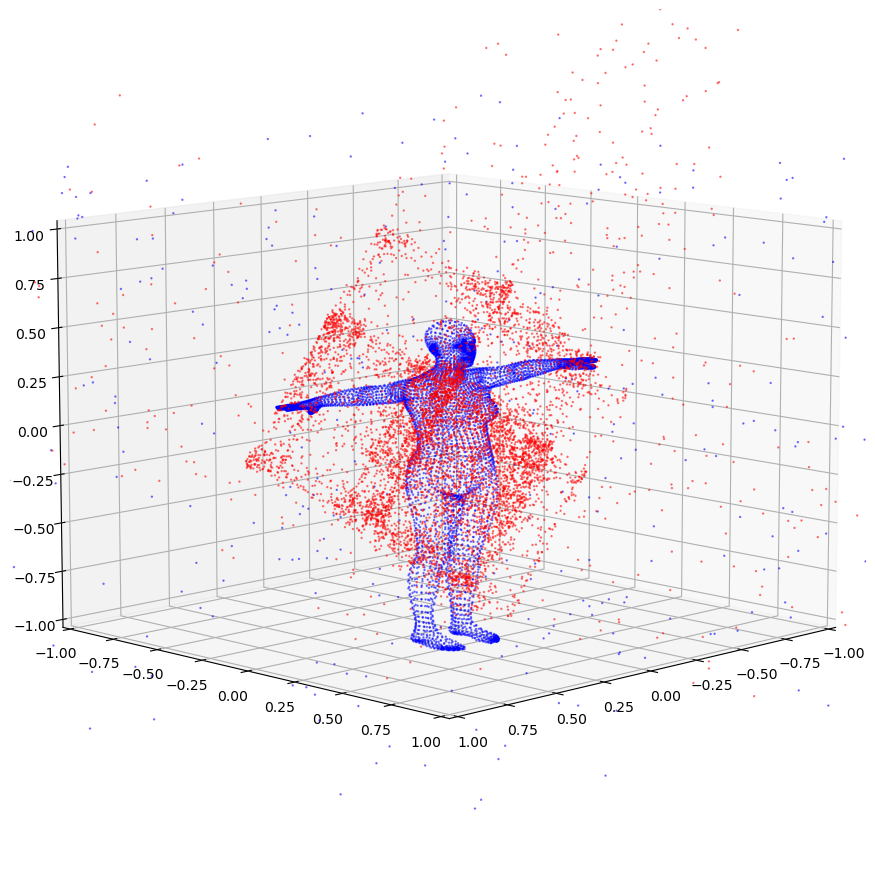

error 0.03143254549663081
epoch 2
Lambda 40.34823162085958


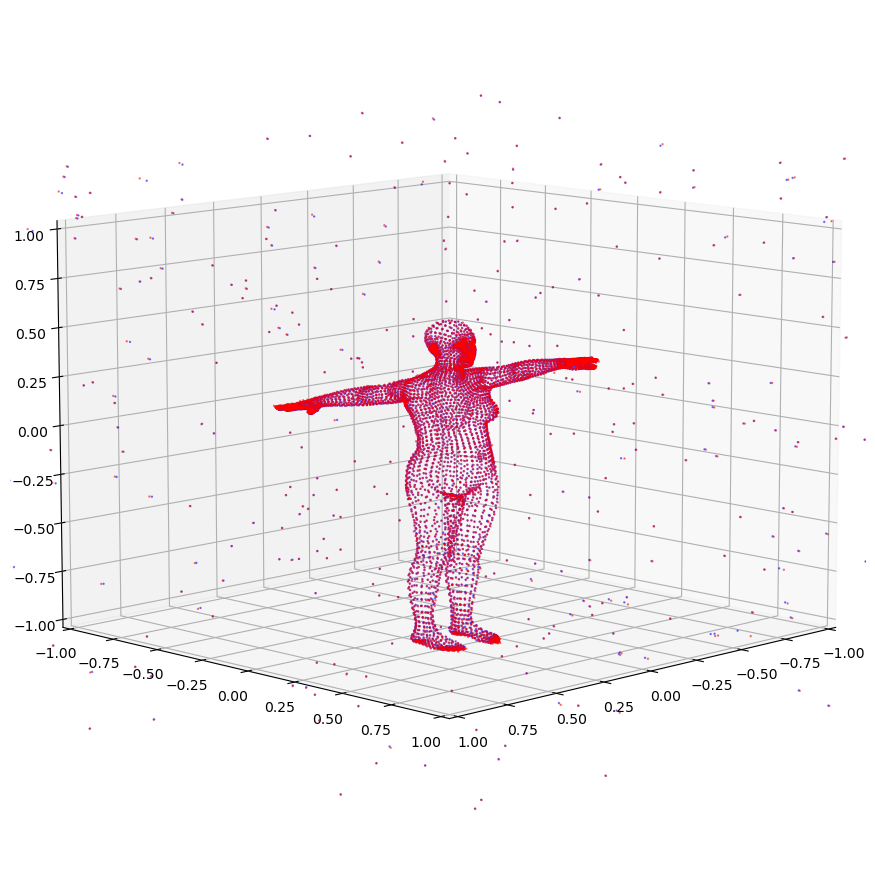

error 0.031309337402191176
epoch 3
Lambda 40.34823162085958


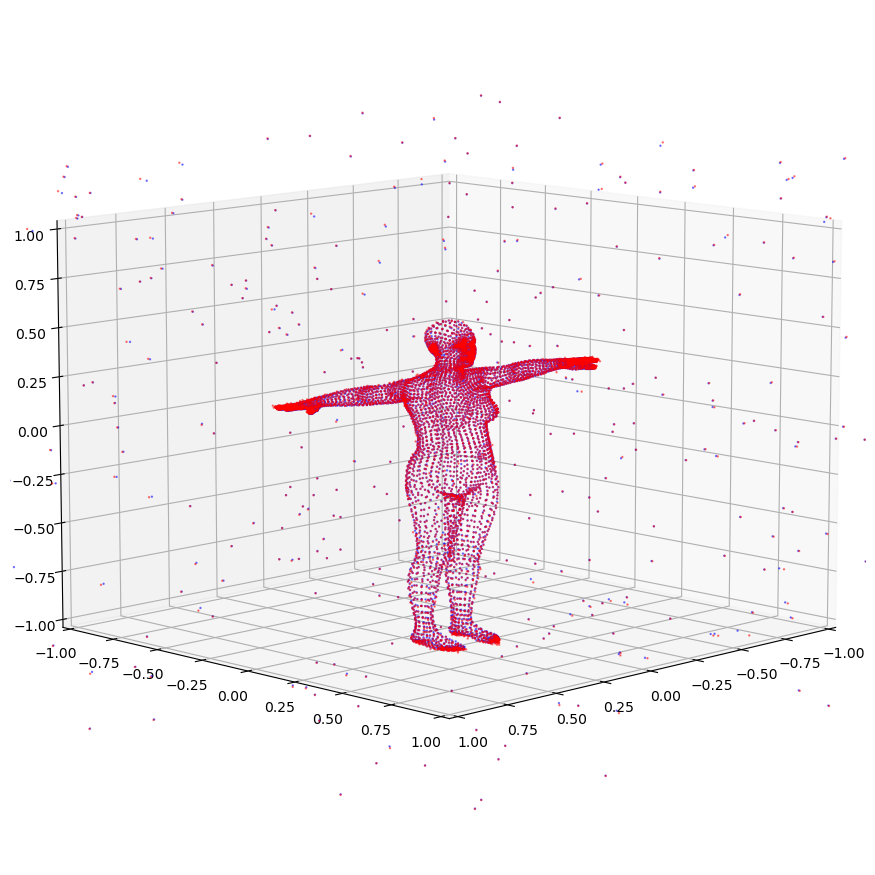

error 0.031309337402191176
epoch 4
Lambda 40.34823162085958


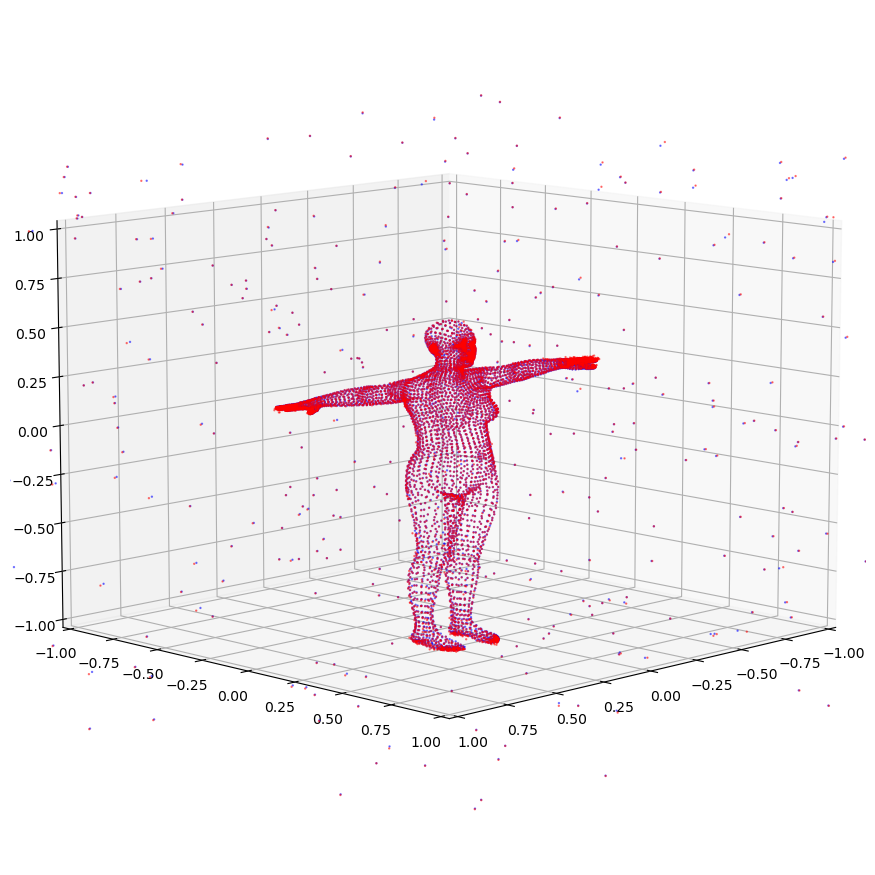

error 0.031309337402191176
epoch 5


KeyboardInterrupt: 

In [146]:
# TPS method

# load data 
i=19
j=2
eta=0.05
label='female'
eps=1e-5
n_projections=50
data=torch.load('data/%s_%d_%d.pt'%(label,i,j))
print(label)
recod_index=[0,1,5,10]
data=torch.load('data/female_%d_%d.pt'%(i,j))
X0=data['X0']
X=data['X'+str(eta)]
Y=data['Y'+str(eta)]
make_plot(X,Y)
N0=X0.shape[0]

N1,D=X.shape
C=X.copy()
Phi0=kernel_matrix_TPS(C,X,D) 
X_bar=np.hstack((np.ones((X.shape[0],1)),X))
# initlize 
R=np.eye(D)    
S=1.0
beta=np.mean(Y,0)-np.mean(X.dot(S).dot(R),0) #np.zeros(3) #vec_mean(Y)-vec_mean(X.dot(S).dot(R)) 
alpha=np.zeros((C.shape[0],D))
B=np.vstack((beta,R))

#paramlist=[]
projections=random_projections(D,n_projections,1)
mass_diff=0
b=np.log((N1-N0+1)/1)
Lambda=60*np.sum((Y.mean(0)-X.mean(0))**2)
Yhat=Phi0.dot(alpha)+X_bar.dot(B)
# make_plot(Yhat,Y)

Domain_org=arange(0,N1)
Delta=Lambda/8
lower_bound=Lambda/10000
L=Domain_org.copy()
Domain_org=np.random.permutation(N1)
Range=np.random.permutation(N1)
Yhat_list=list()

for (epoch,theta) in enumerate(projections):
    print('epoch',epoch)
    # compute correspondence 
    Yhat_theta,Y_theta=np.dot(theta,Yhat.T),np.dot(theta,Y.T)

    # Yhat_indice,Y_indice=Yhat_theta.argsort(),Y_theta.argsort()
    # Yhat_s,Y_s=Yhat_theta[Yhat_indice],Y_theta[Y_indice]
    # obj,phi,psi,piRow,piCol=solve_opt(Yhat_s,Y_s,Lambda)
    # L=piRow.copy()
    # L=recover_indice(Yhat_indice,Y_indice,L)
    # Domain=Domain_org[L>=0]

    #move selected Yhat
    # mass=Domain.shape[0]
    # Range=L[Domain]
    # L=np.arange(n)
    Domain=Domain_org
    Yhat[Domain]+=np.expand_dims(Y_theta[Range]-Yhat_theta[Domain],1)*theta

    # find optimal alpha, B
    #Phi_T,X_bar_select,Y_select=Phi0[Domain][:,Domain],X_bar[Domain],Yhat[Domain]
    #print(Phi_T.shape)
    #alpha1,B=TPS_recover_parameter(Phi_T,X_bar_select,Y_select,eps)
    
    #alpha[Domain]=alpha1
    #print(alpha.max())
    alpha,B=TPS_recover_parameter(Phi0,X_bar,Yhat,eps)


    # update selected points 
    # our model
    Yhat=Phi0.dot(alpha)+X_bar.dot(B)


    # update lambda 
    N=(N1-N0)*1/(1+b*(epoch/500))+N0
    mass_diff=mass-N
    if mass_diff>N*0.009:
        Lambda-=Delta 
    if mass_diff<-N*0.003:
        Lambda+=Delta
        Delta=Lambda*1/8
    if Lambda<Delta:
        Lambda=Delta
        Delta=Delta*1/2
    if Delta<lower_bound:
        Delta=lower_bound
    print('Lambda',Lambda)

    # recode point cloud in the process
    if epoch in recod_index or epoch==n_projections-1:
        Yhat_list.append(Yhat)

    make_plot(Yhat,Y)
    error=np.linalg.norm((Yhat_list[-1][0:N0]-Y[0:N0])/np.std(Y[0:N0]))/N0
    print('error', error)
#     elif epoch%100==0: 
#         make_plot(Yhat,Y)
        






In [126]:
Domain=np.arange(30)
Phi_T,X_bar_select,Y_select=Phi0[Domain][:,Domain],X_bar[Domain],Yhat[Domain]
print(Phi_T.shape)
alpha,B=TPS_recover_parameter(Phi_T,X_bar_select,Y_select,eps)
print(X.shape)

(30, 30)
(6890, 3)


In [113]:
n,d=X_bar.shape
n,K=Phi_T.shape
diag_M=np.zeros((n,K))
np.fill_diagonal(diag_M, epsilon)
M=Phi_T+diag_M
Q, R0 = linalg.qr(X_bar)
Q1,Q2=Q[:,0:d],Q[:,d:n]
R=R0[0:d,:]
alpha=Q2.dot(np.linalg.inv(Q2.T.dot(M).dot(Q2))).dot(Q2.T).dot(Y)
B=np.linalg.inv(R).dot(Q1.T).dot(Y-Phi_T.dot(alpha))

ValueError: shapes (26,7234) and (30,30) not aligned: 7234 (dim 1) != 30 (dim 0)

In [74]:
Q2.T.dot(Phi_T).dot(Q2).shape

(6886, 6886)

In [73]:
diag_M.shape

(6890, 6890)

In [50]:
alpha.max()

18941.719702825638

In [ ]:
error_list=list()
for Yhat in Yhat_list:
    error=np.linalg.norm(Yhat[0:N0][etamutation]-Y[0:N0])
    error_list.append(error)
    